# Análisis de Datos Espaciales
![LCD.jpg](attachment:LCD.jpg)
Rafael Grimson (UNSAM - CONICET)

---
#  Notebook 4: Recortes, Índices y Sistemas de coordenadas de referencia
---
Lo que veremos en esta notebook:

- [x] Recortes por slicing
- [x] Álgebra de bandas y cómputo de índices espectrales
- [x] Sistemas de coordenadas de referencia
- [x] Geotransformaciones
- [x] Recortes de imágenes satelitales. Transformación de los metadatos
- [x] Remuestreos, filtrado y cambios de sistemas de coordenadas

### Objetivos de la notebook:

- En esta notebook esperamos que aprendas a ...

### Datos con los que trabajaremos en esta Notebook:

- Capa vectorial de

# 1. Recortes por slicing
#### Realizaremos recortes de imágenes satelitales utilizando slicing

En esta seccion aprenderemos como obtener recortes (subsets) rectangulares de la imagen, haciendo uso del _slicing_ que nos ofrece `numpy`.

Más adelante veremos que hay formas más adecuadas para recortar datos geoespaciales, utilizando archivos vectoriales externos georreferenciados. Por ahora, vamos a lo más sencillo.

Supongamos que queremos recortar la imagen aproximadamente al área demarcada en la SPOT:

![spotRecorte.png](attachment:spotRecorte.png)

Dicho sector va (aproximadamente) de la columna 750 a la 1500, y de la fila 200 hasta la 800. Sobre la variable **spot_apilada** aplicaremos el subset, teniendo cuidado de la indexación en Python.

In [1]:
import rasterio
ds_MS = rasterio.open('data/raw_data/SPOT_20170806_MS_p.tif')
spot_apilada = ds_MS.read()

spot_apilada_rec = spot_apilada[:,200:800,750:1500]
spot_apilada_rec.shape

(4, 600, 750)

La nueva matriz recortada parece tener las dimensiones correctas.

Visualicemos el resultado del recorte en RGB con  la función `plot_rgb` que definimos antes.

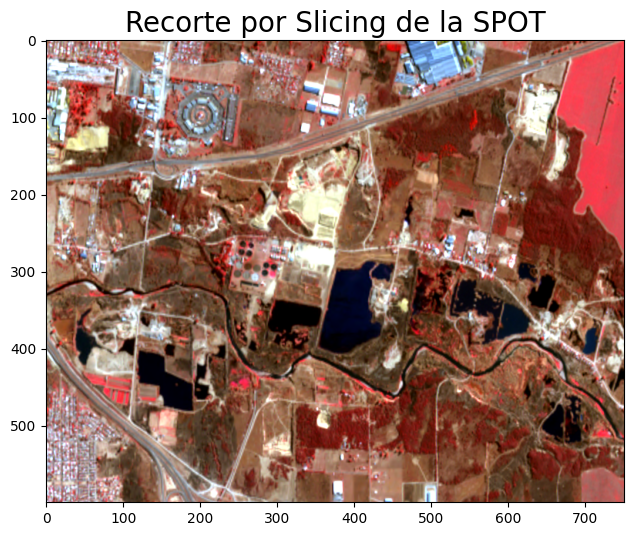

In [2]:
from funciones import *
plot_rgb(spot_apilada_rec, [3,2,1], p=2, figsize = (7.5,6), title = 'Recorte por Slicing de la SPOT' )

### Ejercicio 4.1:

a) Recortá otras zonas de la imagen SPOT, para ejercitar el _slicing_ sobre matrices. Podés probar distintos tipos de superficies, pues en esta imagen tenemos paisajes muy heterogéneos.

b) Para un par de paisajes contrastantes, construí los histogramas de alguna banda (NIR, por ejemplo) y compárlos con el histograma de la imagen completa.

![spotUsos.png](attachment:spotUsos.png)

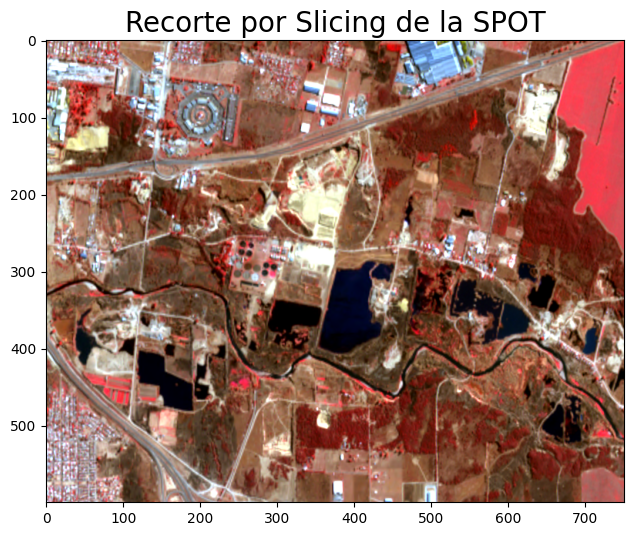

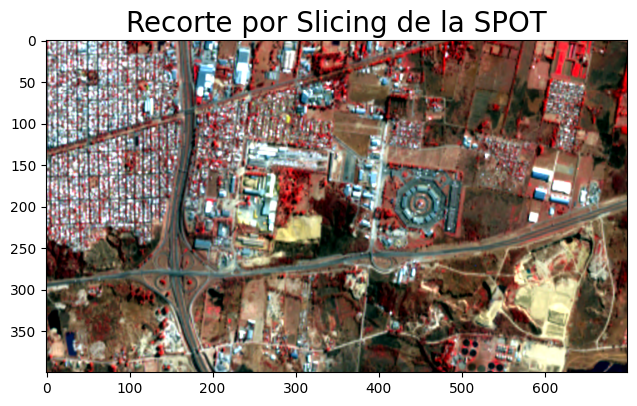

In [5]:
recorte1 = spot_apilada[:, 200:800, 750:1500]    # Ejemplo 1
recorte1.shape

recorte2 = spot_apilada[:, 100:500, 500:1200]  # Ejemplo 2
recorte2.shape

plot_rgb(recorte1, [3,2,1], p=2, figsize = (7.5,6), title = 'Recorte por Slicing de la SPOT' )
plot_rgb(recorte2, [3,2,1], p=2, figsize = (7.5,6), title = 'Recorte por Slicing de la SPOT' )


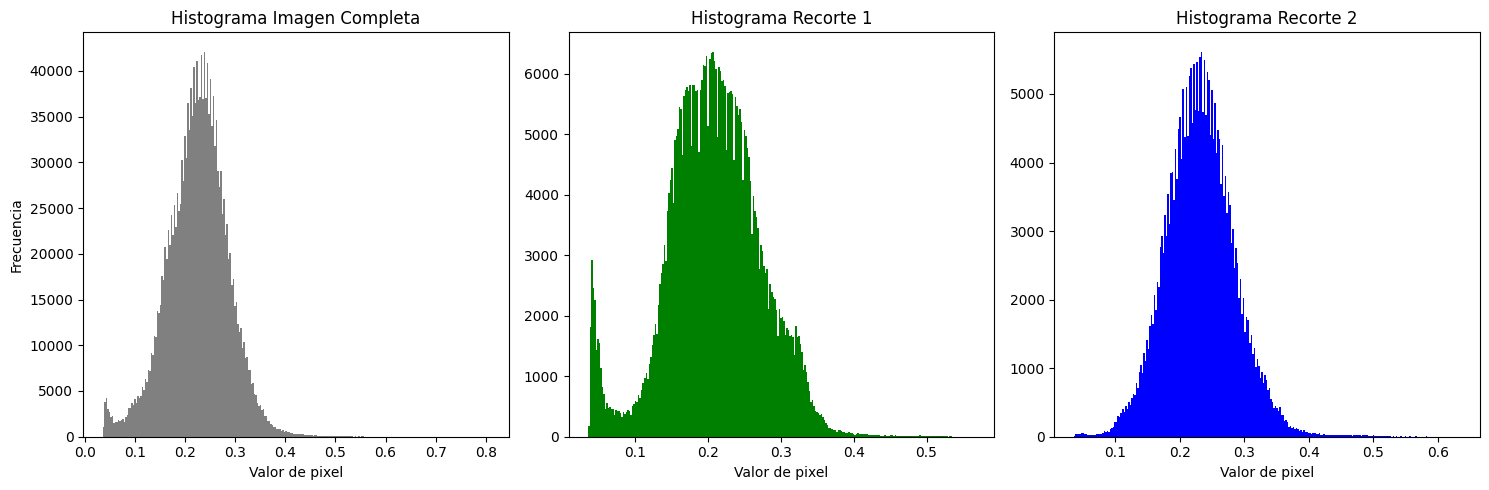

In [6]:
banda_NIR_completa = spot_apilada[3, :, :]
banda_NIR_recorte1 = recorte1[3, :, :]
banda_NIR_recorte2 = recorte2[3, :, :]

plt.figure(figsize=(15,5))

# Histograma de la imagen completa
plt.subplot(1,3,1)
plt.hist(banda_NIR_completa.ravel(), bins=256, color='gray')
plt.title('Histograma Imagen Completa')
plt.xlabel('Valor de pixel')
plt.ylabel('Frecuencia')

# Histograma del primer recorte
plt.subplot(1,3,2)
plt.hist(banda_NIR_recorte1.ravel(), bins=256, color='green')
plt.title('Histograma Recorte 1')
plt.xlabel('Valor de pixel')

# Histograma del segundo recorte
plt.subplot(1,3,3)
plt.hist(banda_NIR_recorte2.ravel(), bins=256, color='blue')
plt.title('Histograma Recorte 2')
plt.xlabel('Valor de pixel')

plt.tight_layout()
plt.show()

# 2. Álgebra de bandas e índices

#### Realizaremos operaciones entre las bandas, como la obtención de índices

## Álgebra de bandas

A continuación vamos a hacer algunas operaciones matemáticas con las bandas de la imagen SPOT multiespectral que tenemos en la variable **spot_apilada**). Dado que las bandas están representadas mediante matrices, podemos realizar operaciones matemáticas con ellas.

Aprovecharemos estas capacidades para calcular dos índices normalizados que de gran uso en la Teledetección Óptica: El Índice de Vegetación Normalizado (o _NDVI_ por sus siglas en inglés), y el Índice de Agua Normalizado (o _NDWI_ por sus siglas en inglés), que trabajarán ustedes en un ejercicio:

$ NDVI = \frac{NIR - R}{NIR + R} $  

Donde $NIR$ se refiere a la banda del Infrarrojo Cercano, y $R$ se refiere a la banda del Rojo (¿Cuáles serían en nuestra SPOT?).

In [ ]:
#Tip: Matplotlib permite abrir los gráficos en una nueva ventana interactiva.
# En el caso de imshow() puede ser interesante para consultar los valores de los píxeles.

# Descomentar la siguiente línea:
# %matplotlib qt

#Si se quiere volver a los ploteos dentro de la celda, correr la siguiente línea:
# %matplotlib inline

In [7]:
import matplotlib.pyplot as plt

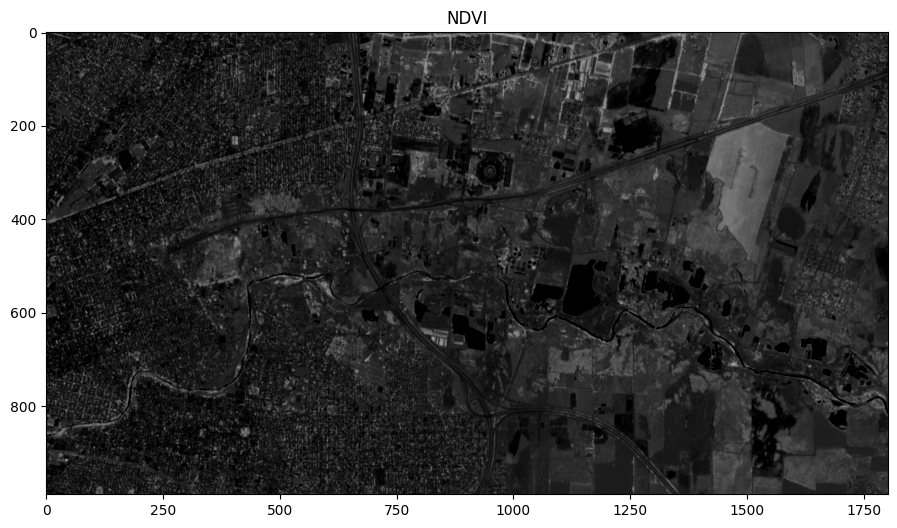

In [8]:
#Cálculo  y visualización del NDVI

# Tip: Recordar que se pueden consultar distintas paletas de color de matplotlib aquí: https://matplotlib.org/stable/tutorials/colors/colormaps.html

b_nir = spot_apilada[3,:,:]
b_red = spot_apilada[2,:,:]

ndvi = (b_nir - b_red) / (b_nir + b_red)

plt.figure(figsize = (12,6))
plt.imshow(ndvi, vmin = 0, vmax = 1, cmap = 'gray')
plt.title("NDVI")
plt.show()

Probemos con otra paleta de color, fijando los límites al NDVI:

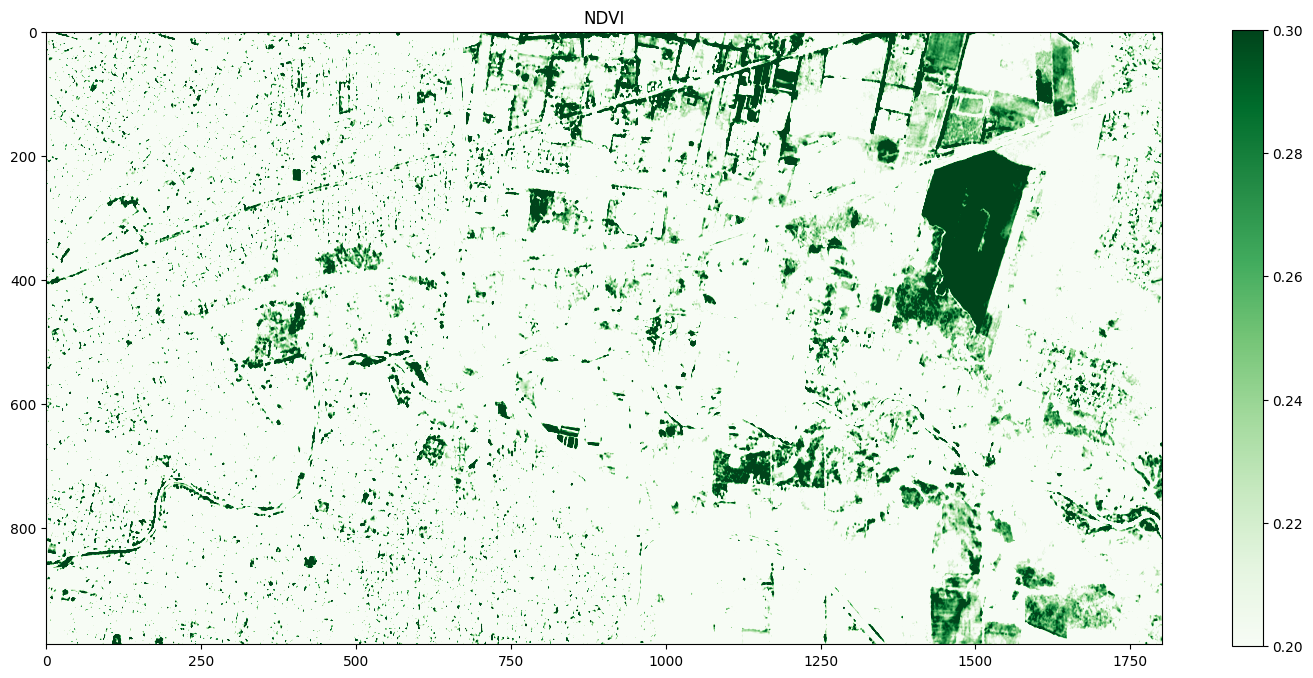

In [9]:
plt.figure(figsize = (18,8))
im = plt.imshow(ndvi, vmin=0.2, vmax=0.3, cmap = 'Greens')
plt.colorbar(im)
plt.title("NDVI")
plt.show()

O escalando con `nequalize` nuestro índice verde:

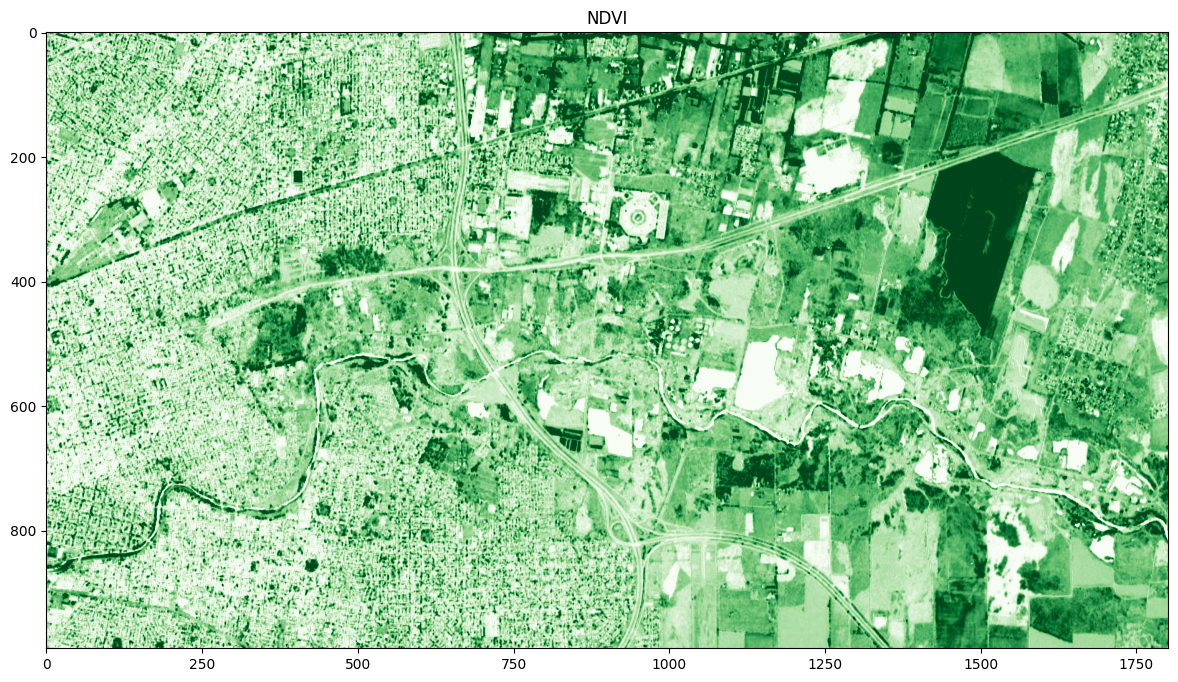

In [10]:
plt.figure(figsize = (18,8))
im = plt.imshow(nequalize(ndvi, p=5), cmap = 'Greens')
plt.title("NDVI")
plt.show()

**Cuidado:** Escalar un índice normalizado a fines de visualización es correcto. Para interpretarciones cuantitativas, simpre debemos usar el índice original y no reescalado.

### Ejercicio 4.3:

Repetir los pasos realizados con el NDVI, para calcular el Ìndice Normalizado de Agua (o NDWI) según la siguiente fórmula:

$ NDWI = \frac{G - NIR}{G + NIR} $

Donde $ G $ corresponde a la banda del verde, y $NIR$ es la misma que utilizamos para el NDVI

**Nota**: La fórmula propuesta para el NDWI corresponde a la formulación de [Mc. Feeters (1996)](https://hess.copernicus.org/articles/22/4349/2018/hess-22-4349-2018-t01.pdf)

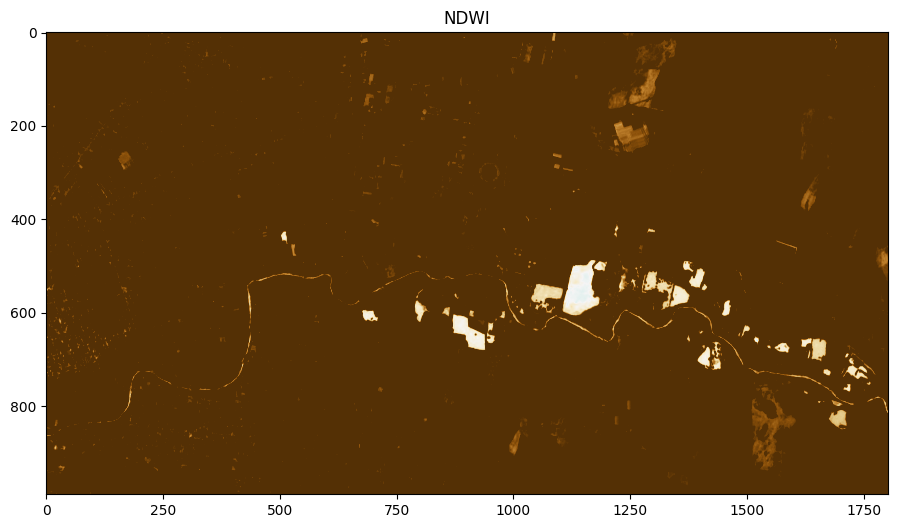

In [11]:
b_nir = spot_apilada[3,:,:]
b_green = spot_apilada[1,:,:]

ndwi = (b_green - b_nir) / (b_green + b_nir)

plt.figure(figsize = (12,6))
plt.imshow(ndwi, vmin = 0, vmax = 1, cmap = 'BrBG')
plt.title("NDWI")
plt.show()

### Ejercicio 4.4:

Leer la imagen Sentinel-2 de la misma zona de estudio (archivo **data/raw_data/S2_20180619_2-3-4-8-11-12.tif**).
Este archivo tiene las bandas 2, 3, 4, 8, 11 y 12 de la Sentinel 2.

- Calcular el NDVI y graficarlo.
- Calcular el NDWI y graficarlo.
- Graficá en una sola imagen RBG el NDVI, el NDWI y el NIR, respectivamente.

*Tip:* Para apilar las bandas sueltas se puede utilizar la función **[stack](https://numpy.org/doc/stable/reference/generated/numpy.stack.html)** de numpy.

In [19]:
ds_MS2 = rasterio.open('data/raw_data/S2_20180619_2-3-4-8-11-12.tif')
imagen_senitnel = ds_MS2.read()
imagen_senitnel.shape

B2_blue = imagen_senitnel[0,:,:]
B3_green = imagen_senitnel[1,:,:]
B4_red = imagen_senitnel[2,:,:]
B8_NIR = imagen_senitnel[3,:,:]
B11_SWIR1 = imagen_senitnel[4,:,:]
B12_SWIR2 = imagen_senitnel[5,:,:]

In [20]:
# NDVI = (NIR - R) / (NIR + R)
ndvi = (B8_NIR - B4_red) / (B8_NIR + B4_red)

# NDWI = (G - NIR) / (G + NIR)
ndwi = (B3_green - B8_NIR) / (B3_green + B8_NIR)

ndvi = np.nan_to_num(ndvi, nan=0.0, posinf=0.0, neginf=0.0)
ndwi = np.nan_to_num(ndwi, nan=0.0, posinf=0.0, neginf=0.0)

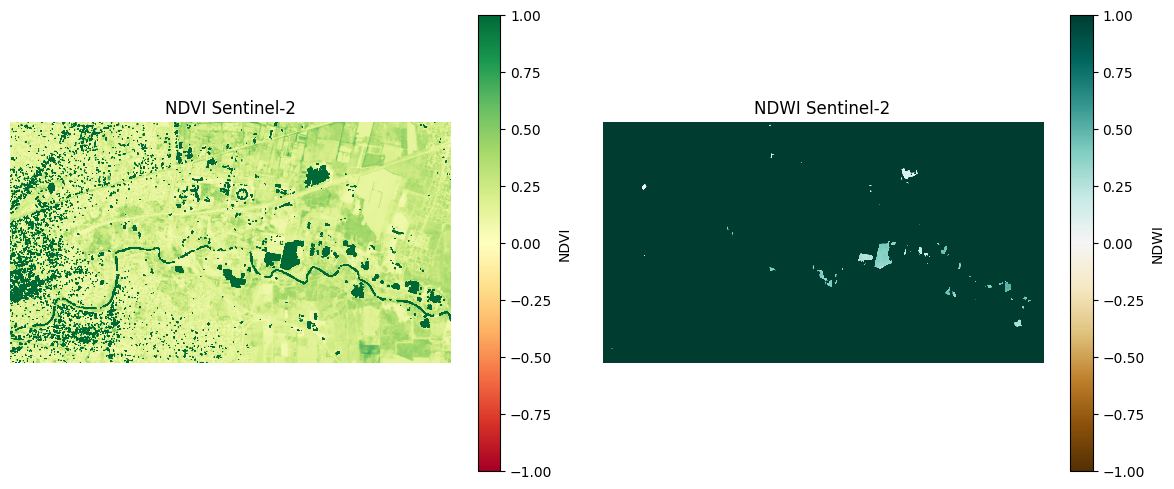

In [21]:
plt.figure(figsize=(12,5))

# NDVI
plt.subplot(1,2,1)
plt.imshow(ndvi, cmap='RdYlGn', vmin=-1, vmax=1)
plt.colorbar(label='NDVI')
plt.title('NDVI Sentinel-2')
plt.axis('off')

# NDWI
plt.subplot(1,2,2)
plt.imshow(ndwi, cmap='BrBG', vmin=-1, vmax=1)
plt.colorbar(label='NDWI')
plt.title('NDWI Sentinel-2')
plt.axis('off')

plt.tight_layout()
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


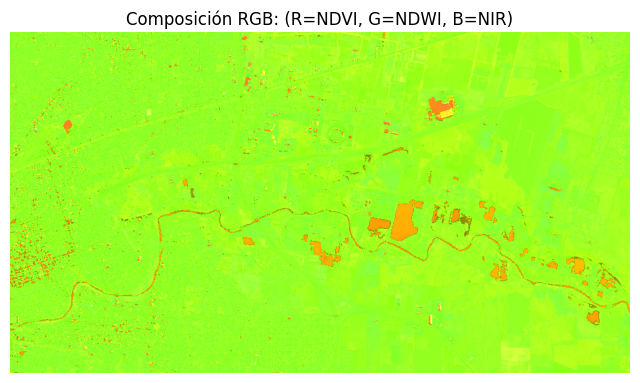

In [18]:
ndvi_norm = (ndvi + 1) / 2   # Porque NDVI y NDWI van de -1 a 1
ndwi_norm = (ndwi + 1) / 2
nir_norm = (B8_NIR - B8_NIR.min()) / (B8_NIR.max() - B8_NIR.min())

# Apilar las tres bandas en orden RGB
rgb = np.stack([ndvi_norm, ndwi_norm, nir_norm], axis=-1)

# Mostrar la imagen
plt.figure(figsize=(8,8))
plt.imshow(rgb)
plt.title('Composición RGB: (R=NDVI, G=NDWI, B=NIR)')
plt.axis('off')
plt.show()

# 3. Sistemas de coordenadas de referencia. Geoides y Proyecciones

## Proyecciones mas frecuentes: cilíndrica, cónica y plana
![image-3.png](attachment:image-3.png)

Ver el [manual de QGIS](https://docs.qgis.org/3.22/es/docs/gentle_gis_introduction/coordinate_reference_systems.html)

## Elipsoides
![image-2.png](attachment:image-2.png)

## Geoides
![image.png](attachment:image.png)

### El WGS 84
Es el geoide más utilizado. El sistema GPS se basa en él. Las coordenadas son geográficas: no están proyectadas.
Más sobre el [WGS 84](https://es.wikipedia.org/wiki/WGS84)

## La proyección UTM
### Universal Transversal Mercator
![image-2.png](attachment:image-2.png)
![image.png](attachment:image.png)

### Características de UTM: Ancho de 6 grados, origen en el ecuador (positivo hacia el oeste), N o S según para donde sea positivo.
![image-3.png](attachment:image-3.png)

## ¿Cómo funciona esto en `rasterio`?

In [26]:
import rasterio
import numpy as np
ds = rasterio.open('data/raw_data/SPOT_20170806_MS_p.tif')

In [27]:
crs = ds.crs
print(crs)

EPSG:32720


### EPSG:32720: Corresponde a WGS 84 / UTM zone 20S



![image.png](attachment:image.png)

# 4. Geotransformaciones
### Además del sistema de coordenadas, tenemos la geotransformación

In [28]:
geoTs = ds.transform
print(geoTs)

| 6.00, 0.00, 388865.79|
| 0.00,-6.00, 6528057.48|
| 0.00, 0.00, 1.00|


La geotransformación representa una transformación afín, escrita en notación matricial
![image.png](attachment:image.png)


Los términos de esta ecuación típicamente se interpretan así:
- el vector $\vec x = (columna, fila)$ representa las coordenadas de un pixel de la matriz,
- la matriz $A$ es una matriz diagonal, indicando la resolución de cada pixel de la imagen,
- el vector $\vec b$ contiene las coordenadas (del CRS) del la esquina superior izquieda de la imagen,
- el vector $\vec y$ contiene las coordenadas (del CRS) del pixel representado por $\vec x$.

### Geotransformaciones

Consiste en una tupla de 6 valores que contienen la información necesaria para realizar la transformación de matriz, a imagen georreferenciada en un mapa. Contiene los siguientes elementos:


>
**GT(0)** = Tamaño del píxel en sentido Oeste-Este\
**GT(1)** = Parámetro de rotación de las filas (Normalmente es cero)\
**GT(2)** = Coordenada x de la esquina superior izquierda del píxel superior izquierdo de la matriz\
**GT(3)** = Parámetro de rotación de las columnas (Normalmente es cero)\
**GT(4)** = Tamaño del píxel en sentido Norte-Sur (Este valor normalmente es negativo si el norte de la imagen coincide con la parte superior de la matriz)
**GT(5)** = Coordenada y de la esquina superior izquierda del píxel superior izquierdo de la matriz\

![geots.png](attachment:geots.png)

#### Cómo funciona?

X_geo = GT(0) + X_mat * GT(1) + Y_mat * GT(2)

Y_geo = GT(3) + X_mat * GT(4) + Y_mat * GT(5)

Para obtener más información acerca de las Geotransformaciones vaisitá el siguiente [enlace](https://gdal.org/tutorials/geotransforms_tut.html)

Los parámetros de Geotransformación de la imagen se obtienen de la siguiente manera:

In [29]:
band_pan = ds.read()[0]
band_pan.shape

(989, 1802)

Veamos cómo obtener la coordenada geográfica del píxel (200,300) de la imagen cargada anteriormente a partir de sus geotransformaciones:

In [30]:
p_x = 300
p_y = 200

ulx = geoTs[2]
uly = geoTs[5]

p_size_x = geoTs[0]
p_size_y = geoTs[4]

coord_x = ulx + p_x*p_size_x
coord_y = uly + p_y*p_size_y

print(f'Coordenadas x,y para la esquina superior izquierda del pixel ({p_y}, {p_x}) de la matriz: {coord_x:.3f}, {coord_y:.3f}')
print(f'Coordenadas x,y para el centro del pixel ({p_y}, {p_x}) de la matriz : {coord_x+p_size_x/2:.3f}, {coord_y+p_size_y/2:.3f}')


Coordenadas x,y para la esquina superior izquierda del pixel (200, 300) de la matriz: 390665.375, 6526856.884
Coordenadas x,y para el centro del pixel (200, 300) de la matriz : 390668.374, 6526853.883


### Ejercicio 4.5:

1. Calculá las coordenadas del extremo inferior derecho de la imágen `ds`. En metros, ¿cuán ancha y cuán larga es la imágen?

1. A partir de las siguientes coordenadas de una ventana:
 ```
 ul_x, ul_y = 389015.8, 6527907.5 # Esquina superior izquierda
 lr_x, lr_y = 391265.9, 6525657.5 # Esquina inferior derecha
 ```
 Calculá los parámetros x_off, y_off, win_xsize y win_ysize de manera que la matriz
  ```
  clip = band_pan[x_off:(x_off+win_xsize), y_off:(y_off+win_ysize)]
  ```
  tenga la imagen correspondiente a la ventana seleccionada (recordá que x_off, y_off, win_xsize y win_ysize deben ser números enteros).

 ![ejercicio_subset.png](attachment:ejercicio_subset.png)

2. A partir del código anterior, definí una función que genere un recorte a partir de unas coordenadas y una imagen suministrada. La función deberá tener la siguiente estructura:

 ```
 ul_x, ul_y = 389015.794, 6527907.484
 lr_x, lr_y = 391265.904, 6525657.498

 ds = rasterio.open('data/raw_data/SPOT_20170806_PAN.tif')

 def subset_img(ds, ulx, uly, lrx, lry):
     '''
     Descripción de la función
     '''
     
     código....
     return clip

 clip = subset_img(ds, ul_x, ul_y, lr_x, lr_y)

 ```


# 5. Escritura de archivos recortados

Ahora que tenemos recortados nuestros archivos y que hemos generado algunos productos nuevos, veamos como guardarlos como geoTiff con la georeferenciación adecuada.

Hay algunas cuestiones a considerar, como ser:

- El sistema de coordenadas de nuestro archivo ariginal, que leímos al principio de la notebook en la variable _crs_
- En qué formato vamos a querer guardar nuestro raster (seguimos con GeoTiff)
- El tipo de dato del archivo que queremos guardar (principalmente si será un raster con números enteros o flotantes).
- Las dimensiones del archivo que queremos guardar: Recordar que ahora estamos almacenando un recorte de nuestra imagen orginal.
- La cantidad de bandas.
- Idealmente, un nombre para cada banda.
- La geotransformación o _geotransform_ , que hemos leido al principio de la notebook en la variable _geoTs_ ,pero que ahora deberemos adaptar a nuestro recorte.

Empecemos por revisar este último parámetro, que en realidad es el único que requiere trabajo.

In [31]:
print(geoTs)

| 6.00, 0.00, 388865.79|
| 0.00,-6.00, 6528057.48|
| 0.00, 0.00, 1.00|


Ya vimos qué es cada uno de los parámetros que contiene la GeoTransformación.

Nuestro recorte comparte casi todos los atributos de la geotransformación con la imagen original, excepto las coordenadas de la esquina superior izquierda. Efectivamente, las coordenadas de la esquina superior izquierda de nuestro recorte no son las mismas que las de la imagen original, y de alguna manera tenemos que poder recalcularlas.

Nosotros hicimos el recorte de la SPOT con el siguiente código:

    spot_apilada[:,200:800,750:1500]

Es decir que la esquina superior izquierda estaría ubicada en la fila 200, columna 750:


Sabiendo eso, podemos calcular el desplazamiento en coordenadas que necesitamos para llegar a nuestro nuevo punto superior izquierdo:

In [32]:
print(geoTs[0]*750 + geoTs[2])
print(geoTs[4]*200 + geoTs[5])

393364.75768423977
6526856.88441001


### O, más sencillo, usando la magia del álgebra lineal, tenemos:
(ver [aca](https://pygis.io/docs/d_raster_crs_intro.html) para más info)

In [33]:
geoTs*(750,200)

(393364.75768423977, 6526856.88441001)

Con esto podemos crearnos la geotransformación adecuada para el recorte (usamos la función Affine de rasterio). Podemos simplemente rearmar **geoTs** armarla manualmente, respetando el orden y la estructura original. Reutilizaremos todos los elementos de **geoTs** , salvo los que hemos calculado, y con es construiremos una variable nueva que se llame **geoTs_rec**:

In [34]:
from rasterio import Affine

ulx , uly = geoTs*(750,200) #desplazo con la transformación afín las coordenadas UL.

geoTs_rec = Affine(geoTs[0], geoTs[1], ulx, geoTs[3], geoTs[4], uly)

print(f'GeoTs original: \n{geoTs}\n\nGeoTs del recorte: \n{geoTs_rec}')

GeoTs original: 
| 6.00, 0.00, 388865.79|
| 0.00,-6.00, 6528057.48|
| 0.00, 0.00, 1.00|

GeoTs del recorte: 
| 6.00, 0.00, 393364.76|
| 0.00,-6.00, 6526856.88|
| 0.00, 0.00, 1.00|


Otra propiedad que debemos especificar es el Sistema de Coordenadas del raster que almacenaremos. En nuestro caso, fue leído al principio de la notebook como **crs**:

In [36]:
crs

CRS.from_wkt('PROJCS["WGS 84 / UTM zone 20S",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-63],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",10000000],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32720"]]')

#### La siguiente función guarda un GeoTiff a partir de una matriz con la/s banda/s y toda la información que venimos mencionando:

In [39]:
def guardar_GTiff(fn, crs, transform, mat, meta=None, nodata=None, bandnames=[]):
    if len(mat.shape)==2:
        count=1
    else:
        count=mat.shape[0]

    if not meta:
        meta = {}

    meta['driver'] = 'GTiff'
    meta['height'] = mat.shape[-2]
    meta['width'] = mat.shape[-1]
    meta['count'] = count
    meta['crs'] = crs
    meta['transform'] = transform

    if 'dtype' not in meta: #if no datatype is specified, use float32
        meta['dtype'] = np.float32


    if nodata:
        meta['nodata'] = nodata

    with rasterio.open(fn, 'w', **meta) as dst:
        if count==1: #es una matriz bidimensional, la guardo
            dst.write(mat.astype(meta['dtype']), 1)
            if bandnames:
                dst.set_band_description(1, bandnames[0])
        else: #es una matriz tridimensional, guardo cada banda
            for b in range(count):
                dst.write(mat[b].astype(meta['dtype']), b+1)
            for b,bandname in enumerate(bandnames):
                dst.set_band_description(b+1, bandname)#


### Así puedo guardar el recorte

In [40]:
fn = 'data/proc/SPOT_rec.tif'
guardar_GTiff(fn, crs, geoTs_rec, spot_apilada_rec) #, bandnames = ['Blue','Green','Red','NIR'])

### y también índices derivados de la SPOT orioginal

In [41]:
fn = 'data/proc/SPOT_NDVI.tif'
guardar_GTiff(fn, crs, geoTs, ndvi)

### Ejercicio 4.6

1. Abrir en QGIS las diferentes imágenes trabajadas en esta clase. Poner las bandas RGB adecuadas.
2. Calcular un nuevo recorte (a elección) de la SPOT y guardar en una sola imagen GeoTiff las 4 bandas originales recortadas, el NDVI y el NDWI, con sus nombres respectivos.

**Nota**: Prestar atención al tipo de dato que se debe usar para los píxeles del NDVI y el NDWI

In [62]:
import os
import numpy as np

# Recorte
recorte3 = spot_apilada[:, 300:900, 1300:1900]

# Bandas originales
b_nir = recorte3[3, :, :]
b_green = recorte3[1, :, :]
b_red = recorte3[2, :, :]
b_blue = recorte3[0, :, :]

# Índices
ndwi = (b_green - b_nir) / (b_green + b_nir)
ndvi = (b_nir - b_red) / (b_nir + b_red)

# Conversión de índices a float32
ndwi = ndwi.astype(np.float32)
ndvi = ndvi.astype(np.float32)

# Apilar todo
recorte3 = np.stack([b_blue, b_green, b_red, b_nir, ndwi, ndvi], axis=0)

# Archivo de salida
fn = 'data/proc/SPOT_rec3.tif'

# Crear carpeta si no existe
os.makedirs(os.path.dirname(fn), exist_ok=True)

# Geotransformación ajustada
ulx, uly = geoTs * (1300, 300)
geoTs_recorte3 = Affine(geoTs[0], geoTs[1], ulx, geoTs[3], geoTs[4], uly)

# Guardar
guardar_GTiff(fn, crs, geoTs_recorte3, recorte3)

## Plotear con georeferencias
`show(src)`
o
`show(src.read(), transform=src.transform)`

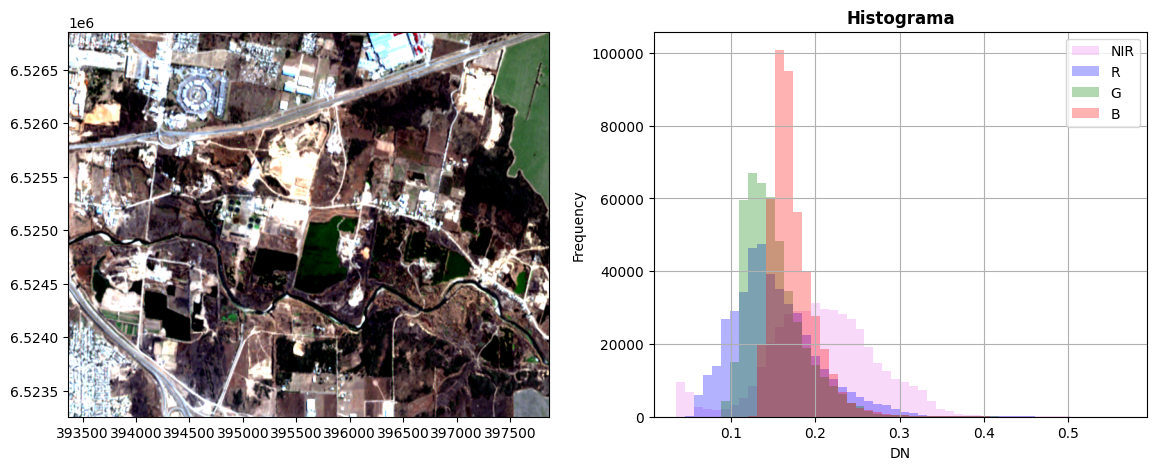

In [60]:
from rasterio.plot import show_hist
fig, (axrgb, axhist) = plt.subplots(1, 2, figsize=(14,5))
show(nequalize(spot_apilada_rec[[2,1,0]],p=10), transform = geoTs_rec, ax = axrgb)
show_hist(
    spot_apilada_rec, bins=50, lw=0.0, stacked=False, alpha=0.3,
    histtype='stepfilled', title="Histograma",ax=axhist, label = ['B','G','R','NIR'])


#show_hist(spot_apilada_rec, bins=50, histtype='stepfilled',
#          lw=0.0, stacked=False, alpha=0.3, ax=axhist)
plt.show()

## 4. Remuestreos, filtrado y cambios de sistemas de coordenadas

Con estos conceptos que introdujimos hay una infinidad de posibilidades. Las matrices se puede procesar [aplicándoles filtros](https://scikit-image.org/skimage-tutorials/lectures/1_image_filters.html), y los datos pueden [guardarse en otros sistemas de coordenadas](https://rasterio.readthedocs.io/en/latest/topics/reproject.html). Dejamos algunos links para lxs que quieran profundizar en estos temas.